#### References
1. https://www.hindawi.com/journals/complexity/2021/9985072/
2. https://www.stata.com/features/overview/bayesian-VAR-models/
3. https://ejournal.upi.edu/index.php/JEM/article/view/25742
4. https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html
5. https://barnesanalytics.com/bayesian-auto-regressive-time-series-analysis-pymc3/
6. https://github.com/ChadFulton/scipy2022-bayesian-time-series/blob/main/Poster.ipynb
7. https://github.com/xxl4tomxu98/vector-autoregressive-model-wage-inflations/blob/main/VAR-model.ipynb
8. https://kevinkotze.github.io/ts-9-bvar/

# Modules

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import levene
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.api import VAR
from statsmodels.api import qqplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data wrangling

In [2]:
# Input data
df = pd.read_csv("DATA/!Final.csv")
df.index = pd.to_datetime(df["Unnamed: 0"])
df=df.iloc[:,1:]
df.head()

,Tavg,RR,ff_avg,Sea level (cm)
Unnamed: 0,,,,
2023-01-01,25.9,38.0,2.0,176.153846
2023-01-02,27.2,134.4,3.0,171.076389
2023-01-03,26.7,0.7,2.0,167.580420
2023-01-04,27.0,3.2,2.0,170.379310
2023-01-05,27.5,31.3,3.0,176.531035


In [3]:
# Check for missing value
df.isna().sum()             # No missing value

Tavg              0
RR                0
ff_avg            0
Sea level (cm)    0
dtype: int64

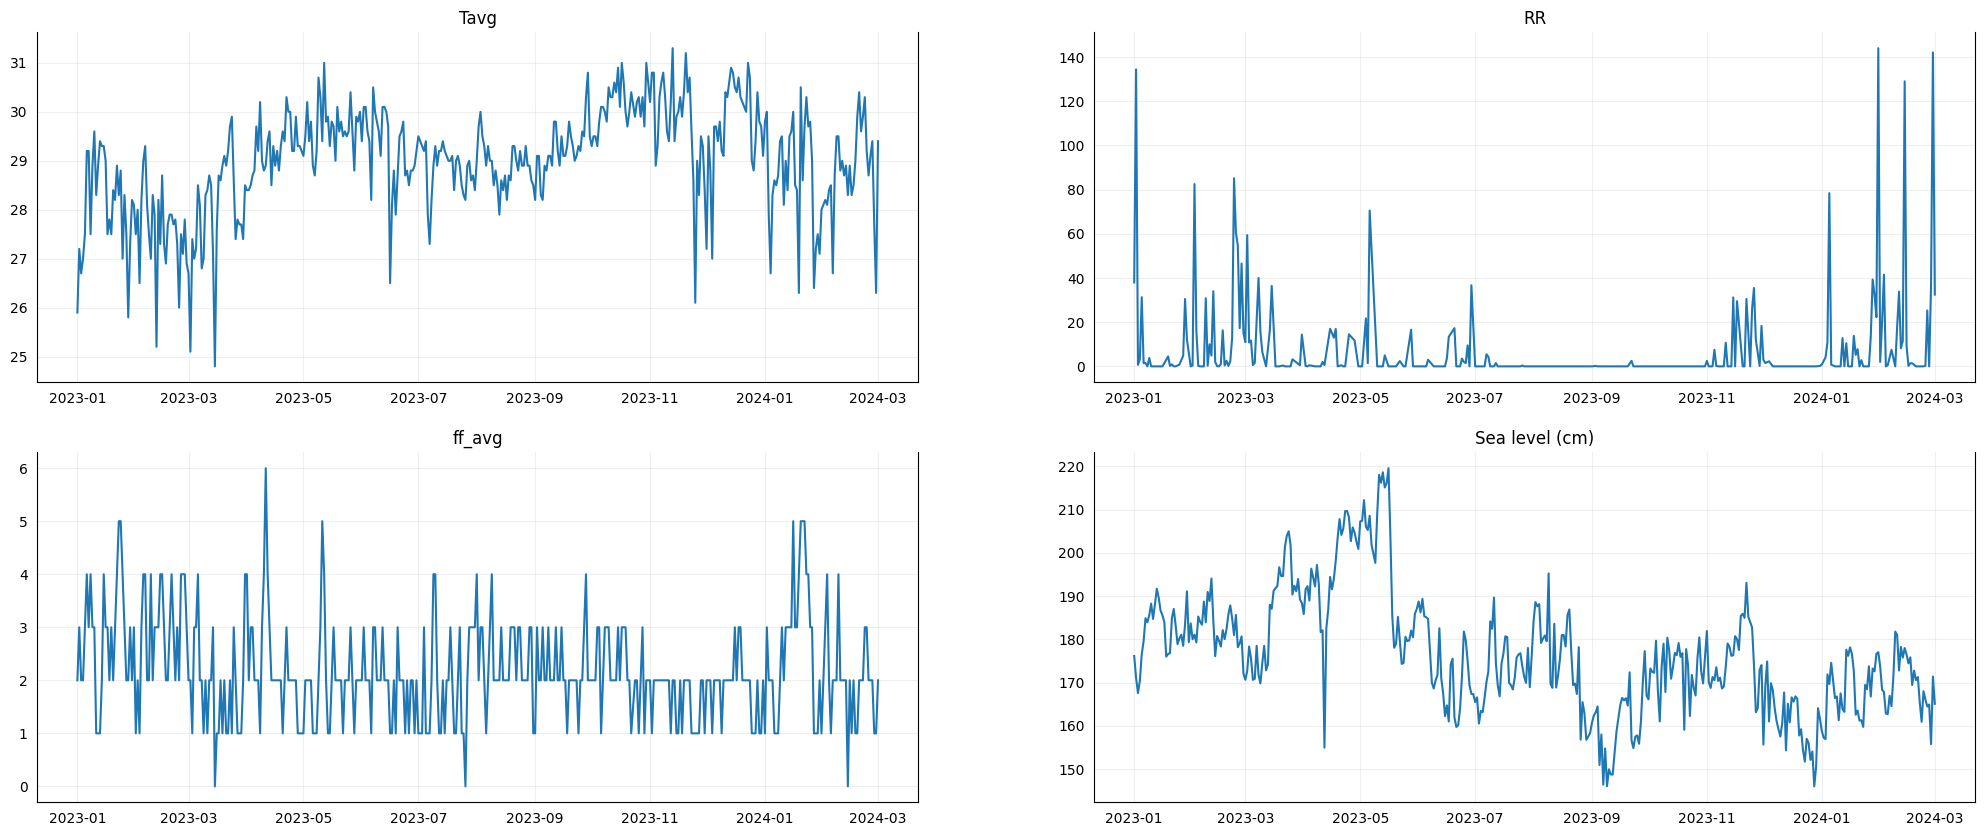

In [4]:
# Plot each columns
fig = plt.figure(figsize=(25,10))
for counter, colname in enumerate(df.columns):
    ax = fig.add_subplot(2, 2, counter+1)
    ax.plot(df[colname])
    ax.set_title(colname)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.grid("on", alpha=0.2)

Data telah dilakukan cleaning dengan baik, sehingga sudah tidak ada lagi amatan yang rusak

In [5]:
df.shape[0]

426

Decompose the the series to find the trend, seasonal and residual components

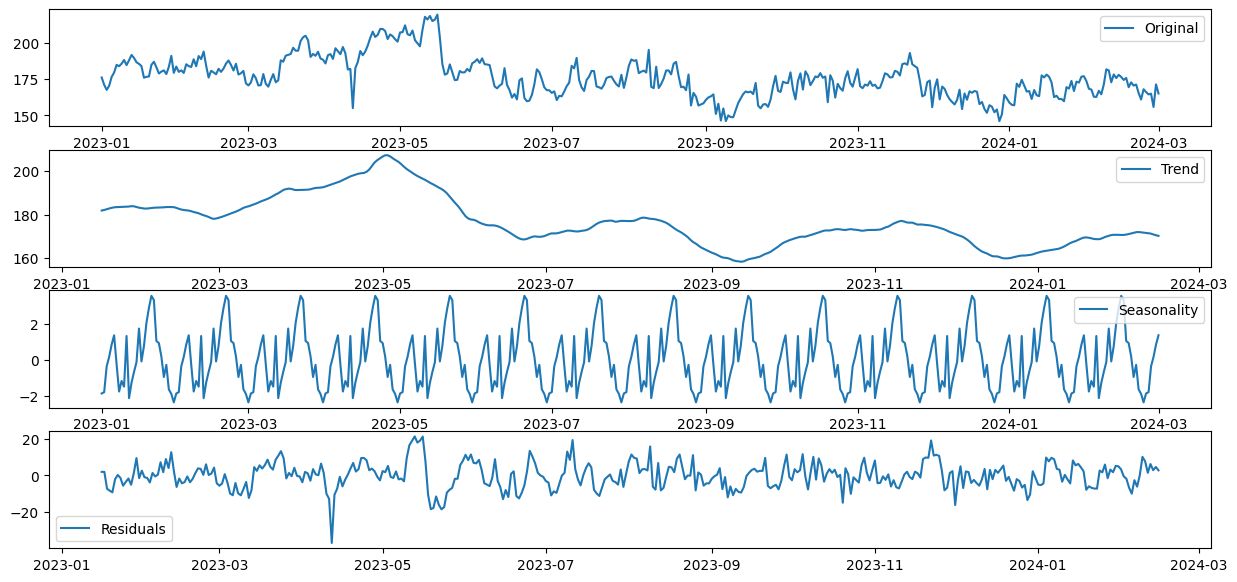

In [6]:
DecomposeResult = seasonal_decompose(df["Sea level (cm)"], period=30)
trend = DecomposeResult.trend
seasonal = DecomposeResult.seasonal
residual = DecomposeResult.resid

def plot_decomposition(original, trend, seasonal, residual):
    """
    Plot the components of a decomposition. Pass in the original univarate data which was decomposed, and then the 
    3 resulting components, being the trend, seasonal and residual parts. 
    """
    # Plot the results
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(4, 1, 1)
    ax.plot(original, label = 'Original')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(trend, label = 'Trend')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(seasonal, label = 'Seasonality')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 4)
    ax.plot(residual, label = 'Residuals')
    ax.legend(loc = 'best')
    return

seasonality_plot = plot_decomposition(df["Sea level (cm)"], trend, seasonal, residual)

## Stasionarity

### Mean

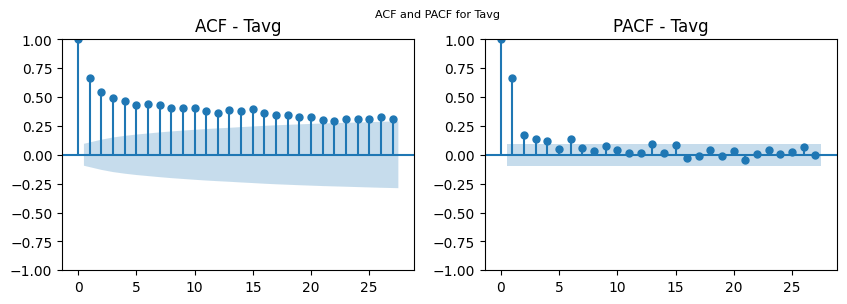

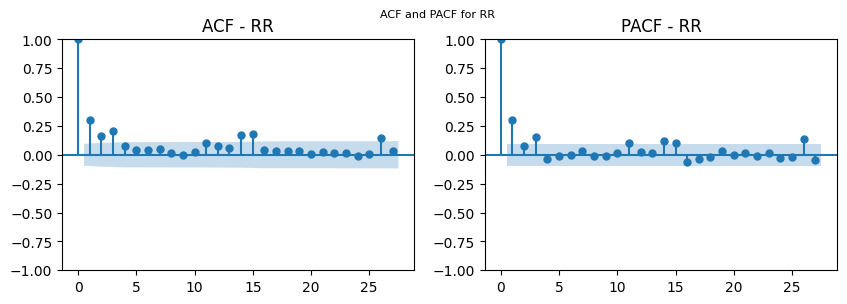

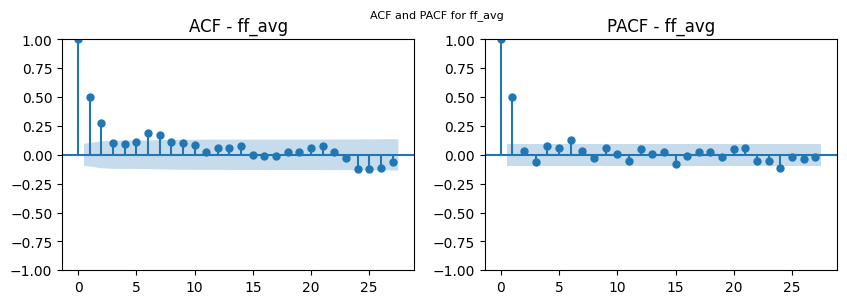

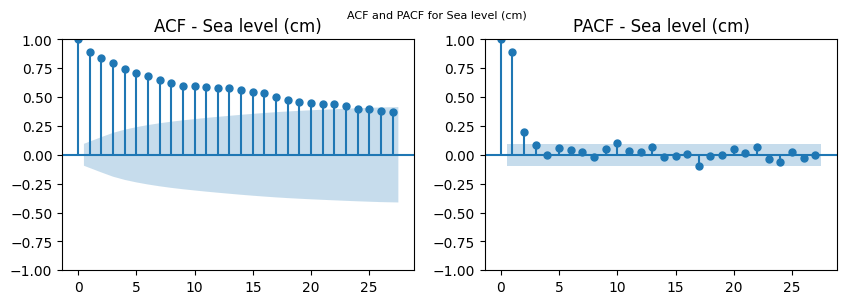

In [7]:
# ACf and PACF
# Plot ACF and PACF for each column
for column in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f'ACF and PACF for {column}', fontsize=8)
    
    # ACF plot
    plot_acf(df[column], ax=axes[0])
    axes[0].set_title(f'ACF - {column}')
    
    # PACF plot
    plot_pacf(df[column], ax=axes[1])
    axes[1].set_title(f'PACF - {column}')
    
    plt.show()

In [7]:
def adf_test(series, title='', signif=0.05):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    p_value=out[1]
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        return True
    print("")
    

non_stationary_columns=[]
for column in df.columns:
    if adf_test(df[column], title=column): non_stationary_columns.append(column)

Augmented Dickey-Fuller Test: Tavg
ADF Test Statistic              -3.853492
p-value                          0.002405
#Lags Used                       5.000000
Number of Observations Used    420.000000
Critical Value (1%)             -3.446016
Critical Value (5%)             -2.868446
Critical Value (10%)            -2.570449
 => P-Value = 0.00240506844620972. Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test: RR
ADF Test Statistic              -2.818103
p-value                          0.055734
#Lags Used                      15.000000
Number of Observations Used    410.000000
Critical Value (1%)             -3.446401
Critical Value (5%)             -2.868615
Critical Value (10%)            -2.570539
 => P-Value = 0.05573406300050517. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
Augmented Dickey-Fuller Test: ff_avg
ADF Test Statistic            -5.812125e+00
p-value                        4.376626e-07
#Lags Used          

C:\Users\Rhey\AppData\Local\Temp\ipykernel_19312\650334246.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value=out[1]
C:\Users\Rhey\AppData\Local\Temp\ipykernel_19312\650334246.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value=out[1]
C:\Users\Rhey\AppData\Local\Temp\ipykernel_19312\650334246.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value=out[1]
C:\Users\Rhey\AppData\Local\Temp\ipykernel_19312\650334

RR Non stationary in mean

In [8]:
df_diff = df.copy()

for column in non_stationary_columns:
    df_diff[f'diff {column}'] = df[column].diff().dropna()
    df_diff = df_diff.drop(column, axis=1)
    
# Drop the first row because differencing introduces NaN
df_diff = df_diff.dropna()

In [9]:
# Recheck
for column in df_diff.columns:
    print(f'{column}: ',end="")
    if adfuller(df_diff[column].dropna(), autolag='AIC')[1]<= 0.05: print('Stationary')
    else: print('Non-Stationary')

Tavg: Stationary
ff_avg: Stationary
Sea level (cm): Stationary
diff RR: Stationary


### Variance

In [10]:
def levene_test(series, num_segments=4):
    """
    Segments the time series into equal parts and applies Levene's test.
    
    Parameters:
    series: Time series data.
    num_segments: Number of segments to divide the data into.
    """
    segment_length = len(series) // num_segments
    segments = [series[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
    
    return levene(*segments)

# Function to check stationarity in variance
def check_variance_stationarity(data):
    results = {}
    for column in data.columns:
        series = data[column].dropna()
        
        # ARCH Test
        arch_test_result = het_arch(series)
        arch_p_value = arch_test_result[1]
        is_arch_non_stationary = arch_p_value < 0.05
        
        # Levene's Test
        levene_test_result = levene_test(series)
        levene_p_value = levene_test_result.pvalue
        is_levene_non_stationary = levene_p_value < 0.05
        
        results[column] = {
            'ARCH Test p-value': arch_p_value,
            'Levene Test p-value': levene_p_value,
            'Non-Stationary in Variance (ARCH)': is_arch_non_stationary,
            'Non-Stationary in Variance (Levene)': is_levene_non_stationary
        }
        
    return results

# Check variance stationarity for each column in the dataset
variance_stationarity_results = check_variance_stationarity(df_diff)

# Print results
for column, result in variance_stationarity_results.items():
    print(f'Column: {column}')
    print(f'ARCH Test p-value: {result["ARCH Test p-value"]}')
    print(f'Non-Stationary in Variance (ARCH): {result["Non-Stationary in Variance (ARCH)"]}')
    print(f'Levene Test p-value: {result["Levene Test p-value"]}')
    print(f'Non-Stationary in Variance (Levene): {result["Non-Stationary in Variance (Levene)"]}')
    print('-' * 50)


Column: Tavg
ARCH Test p-value: 2.502239827465431e-40
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 7.429102577682131e-07
Non-Stationary in Variance (Levene): True
--------------------------------------------------
Column: ff_avg
ARCH Test p-value: 3.307815086373127e-23
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 3.488592815865558e-06
Non-Stationary in Variance (Levene): True
--------------------------------------------------
Column: Sea level (cm)
ARCH Test p-value: 3.834105839963665e-67
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 1.9840670587607522e-12
Non-Stationary in Variance (Levene): True
--------------------------------------------------
Column: diff RR
ARCH Test p-value: 1.1471101485342743e-27
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 1.5486168147123768e-07
Non-Stationary in Variance (Levene): True
--------------------------------------------------


Boxcox and log requires data to have non negative value, data'll be shifted into positive value

Every column is Non stationary in variance

In [11]:
min_value = df_diff.min().min()

# Add a constant to shift the data
shift_constant = 1 - min_value  # This ensures all values are positive

df_diff_shfited = df_diff + shift_constant

LOG Transformation!

In [16]:
def apply_log_transformation(data):
    data_log = data.copy()
    for column in data.columns:
        data_log[column] = np.log1p(data[column])
    return data_log

df_diff_shifted_log = apply_log_transformation(df_diff_shfited)

# Recheck
check_variance_stationarity(df_diff_shifted_log)

{'Tavg': {'ARCH Test p-value': 1.6327281576732037e-39,
  'Levene Test p-value': 6.563008769777734e-07,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'ff_avg': {'ARCH Test p-value': 5.887010260172702e-20,
  'Levene Test p-value': 3.6098227828534695e-06,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'Sea level (cm)': {'ARCH Test p-value': 7.465705504151932e-66,
  'Levene Test p-value': 1.5795925109895025e-11,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'diff RR': {'ARCH Test p-value': 1.3600210580460136e-10,
  'Levene Test p-value': 0.0023434265452754515,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True}}

LOG Transform didn't sucessfully fix non stationary in variance problem, hence box cox transformation will be used

Boxcox transformation

In [25]:
def apply_boxcox_transformation(data):
    data_boxcox = data.copy()
    thelambda = {}
    for column in data.columns:
        data_boxcox[column], fitted_lambda = boxcox(data[column] + 1)  # Add 1 to avoid log(0)
        print(f'Lambda for {column}: {fitted_lambda}')
        thelambda[column] =fitted_lambda
    return data_boxcox


df_diff_shifted_boxcox = apply_boxcox_transformation(df_diff_shfited)
variance_stationarity_results_boxcox = check_variance_stationarity(df_diff_shifted_boxcox)
variance_stationarity_results_boxcox

Lambda for Tavg: 38.685907810091734
Lambda for ff_avg: -36.155213311226866
Lambda for Sea level (cm): -3.6142033469065287
Lambda for diff RR: 1.3260070067462513


{'Tavg': {'ARCH Test p-value': nan,
  'Levene Test p-value': 4.317373812361499e-06,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'ff_avg': {'ARCH Test p-value': 1.0,
  'Levene Test p-value': nan,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': False},
 'Sea level (cm)': {'ARCH Test p-value': 1.0,
  'Levene Test p-value': 1.0133056520609207e-08,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'diff RR': {'ARCH Test p-value': 8.328335322926087e-05,
  'Levene Test p-value': 1.238896014819432e-07,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True}}

In [18]:
pt = PowerTransformer(method='yeo-johnson')

transformed_data = pt.fit_transform(df_diff_shifted_log)
transformed_data = pd.DataFrame(transformed_data, columns=df_diff_shifted_log.columns)

check_variance_stationarity(transformed_data)

c:\Users\Rhey\miniconda3\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Rhey\miniconda3\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


{'Tavg': {'ARCH Test p-value': 1.2452201793516606e-11,
  'Levene Test p-value': 5.065874832370151e-06,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'ff_avg': {'ARCH Test p-value': 1.0,
  'Levene Test p-value': 3.8965592487672955e-06,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'Sea level (cm)': {'ARCH Test p-value': 1.0,
  'Levene Test p-value': 1.3660322677403697e-09,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'diff RR': {'ARCH Test p-value': 3.0817119923919314e-18,
  'Levene Test p-value': 8.330256096123475e-08,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True}}

Yuh even with multiple methods, non stationary in variance problem couldn't get fixed. Nontheless, VAR model's stil usable for use

In [12]:
# Train evaluation test split

# Proposed split 70:20:10
train_data = df_diff.iloc[:int(0.8*df_diff.shape[0]),:]
test_data = df_diff.iloc[len(train_data):,:]

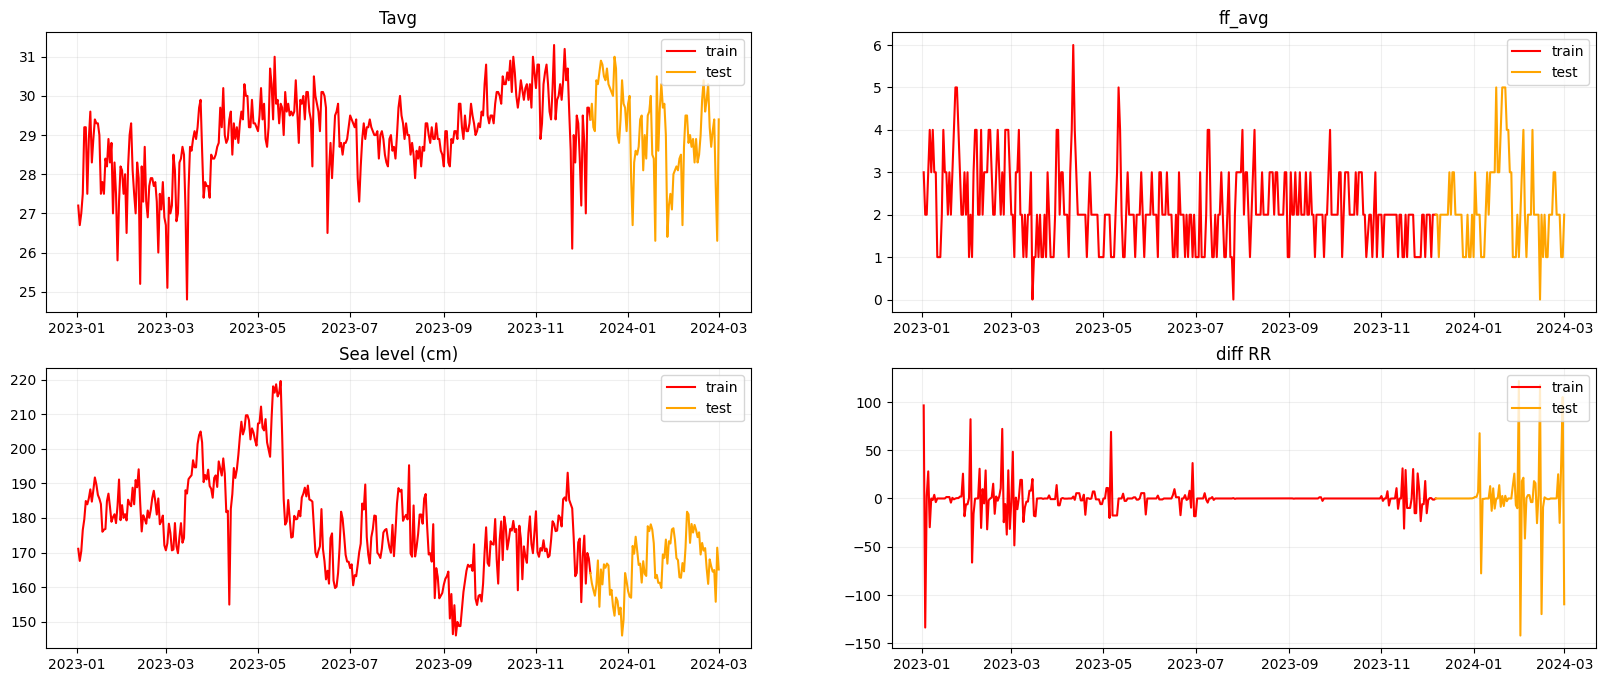

In [354]:
# Plot Train Eval split target only!

colour = ["red", "orange"]
fig = plt.figure(figsize=(20,8))
for counter, column in enumerate(train_data.columns):
    ax = fig.add_subplot(2,2,counter+1)
    ax.plot(train_data[column], label="train", c=colour[0])
    ax.plot(pd.concat((train_data[column].iloc[-1:],  test_data[column])), label="test", c=colour[1])

    ax.set_title(column)
    ax.grid("on", alpha=0.2)
    ax.legend(loc="upper right")

# MODEL

## VAR

### Find lag Variable

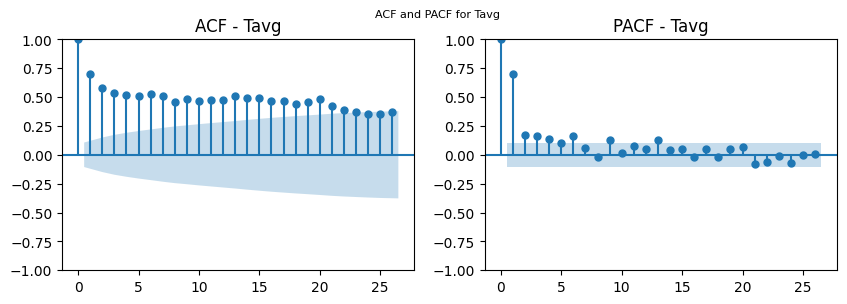

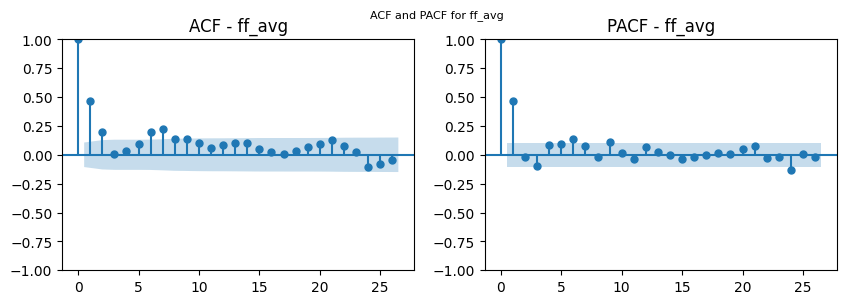

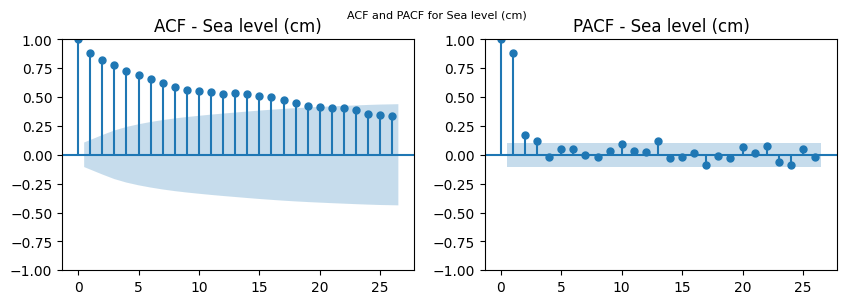

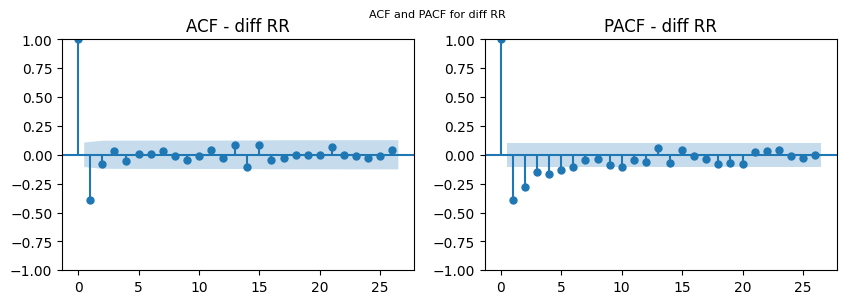

In [47]:
for column in train_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f'ACF and PACF for {column}', fontsize=8)
    
    # ACF plot
    plot_acf(train_data[column], ax=axes[0])
    axes[0].set_title(f'ACF - {column}')
    
    # PACF plot
    plot_pacf(train_data[column], ax=axes[1])
    axes[1].set_title(f'PACF - {column}')
    
    plt.show()

In [79]:
VAR_Model = VAR(train_data)

x = VAR_Model.select_order(maxlags=15)
x.summary()

c:\Users\Rhey\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,10.26,10.30,2.844e+04,10.27
1,7.596,7.829*,1990.,7.689
2,7.430,7.849,1686.,7.597*
3,7.415,8.020,1660.,7.656
4,7.406*,8.197,1646.*,7.722
5,7.454,8.432,1727.,7.844
6,7.460,8.624,1739.,7.925
7,7.517,8.868,1842.,8.056
8,7.570,9.107,1945.,8.183
9,7.569,9.292,1945.,8.257


In [80]:
model_fitted = VAR_Model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Jun, 2024
Time:                     21:44:49
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    8.15218
Nobs:                     336.000    HQIC:                   7.68761
Log likelihood:          -3078.84    FPE:                    1603.61
AIC:                      7.37967    Det(Omega_mle):         1316.31
--------------------------------------------------------------------
Results for equation Tavg
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     6.507545         1.427011            4.560           0.000
L1.Tavg                   0.441913         0.058510            7.553           0.000
L1.ff_avg                 0.004757         0.

### Diagnostic

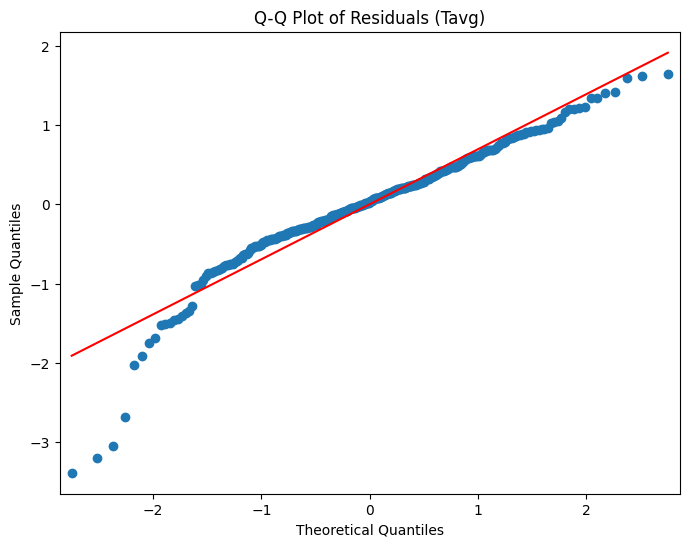

In [81]:
# Uji normalitas residual dengan Q-Q plot
residuals = model_fitted.resid
fig, ax = plt.subplots(figsize=(8, 6))
_ = qqplot(residuals['Tavg'], line='s', ax=ax)
ax.set_title('Q-Q Plot of Residuals (Tavg)')
plt.show()

In [82]:
forecast_steps = len(test_data)
lag_order = model_fitted.k_ar

predictions = model_fitted.forecast(train_data.values[-lag_order:], steps=forecast_steps)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=train_data.columns)

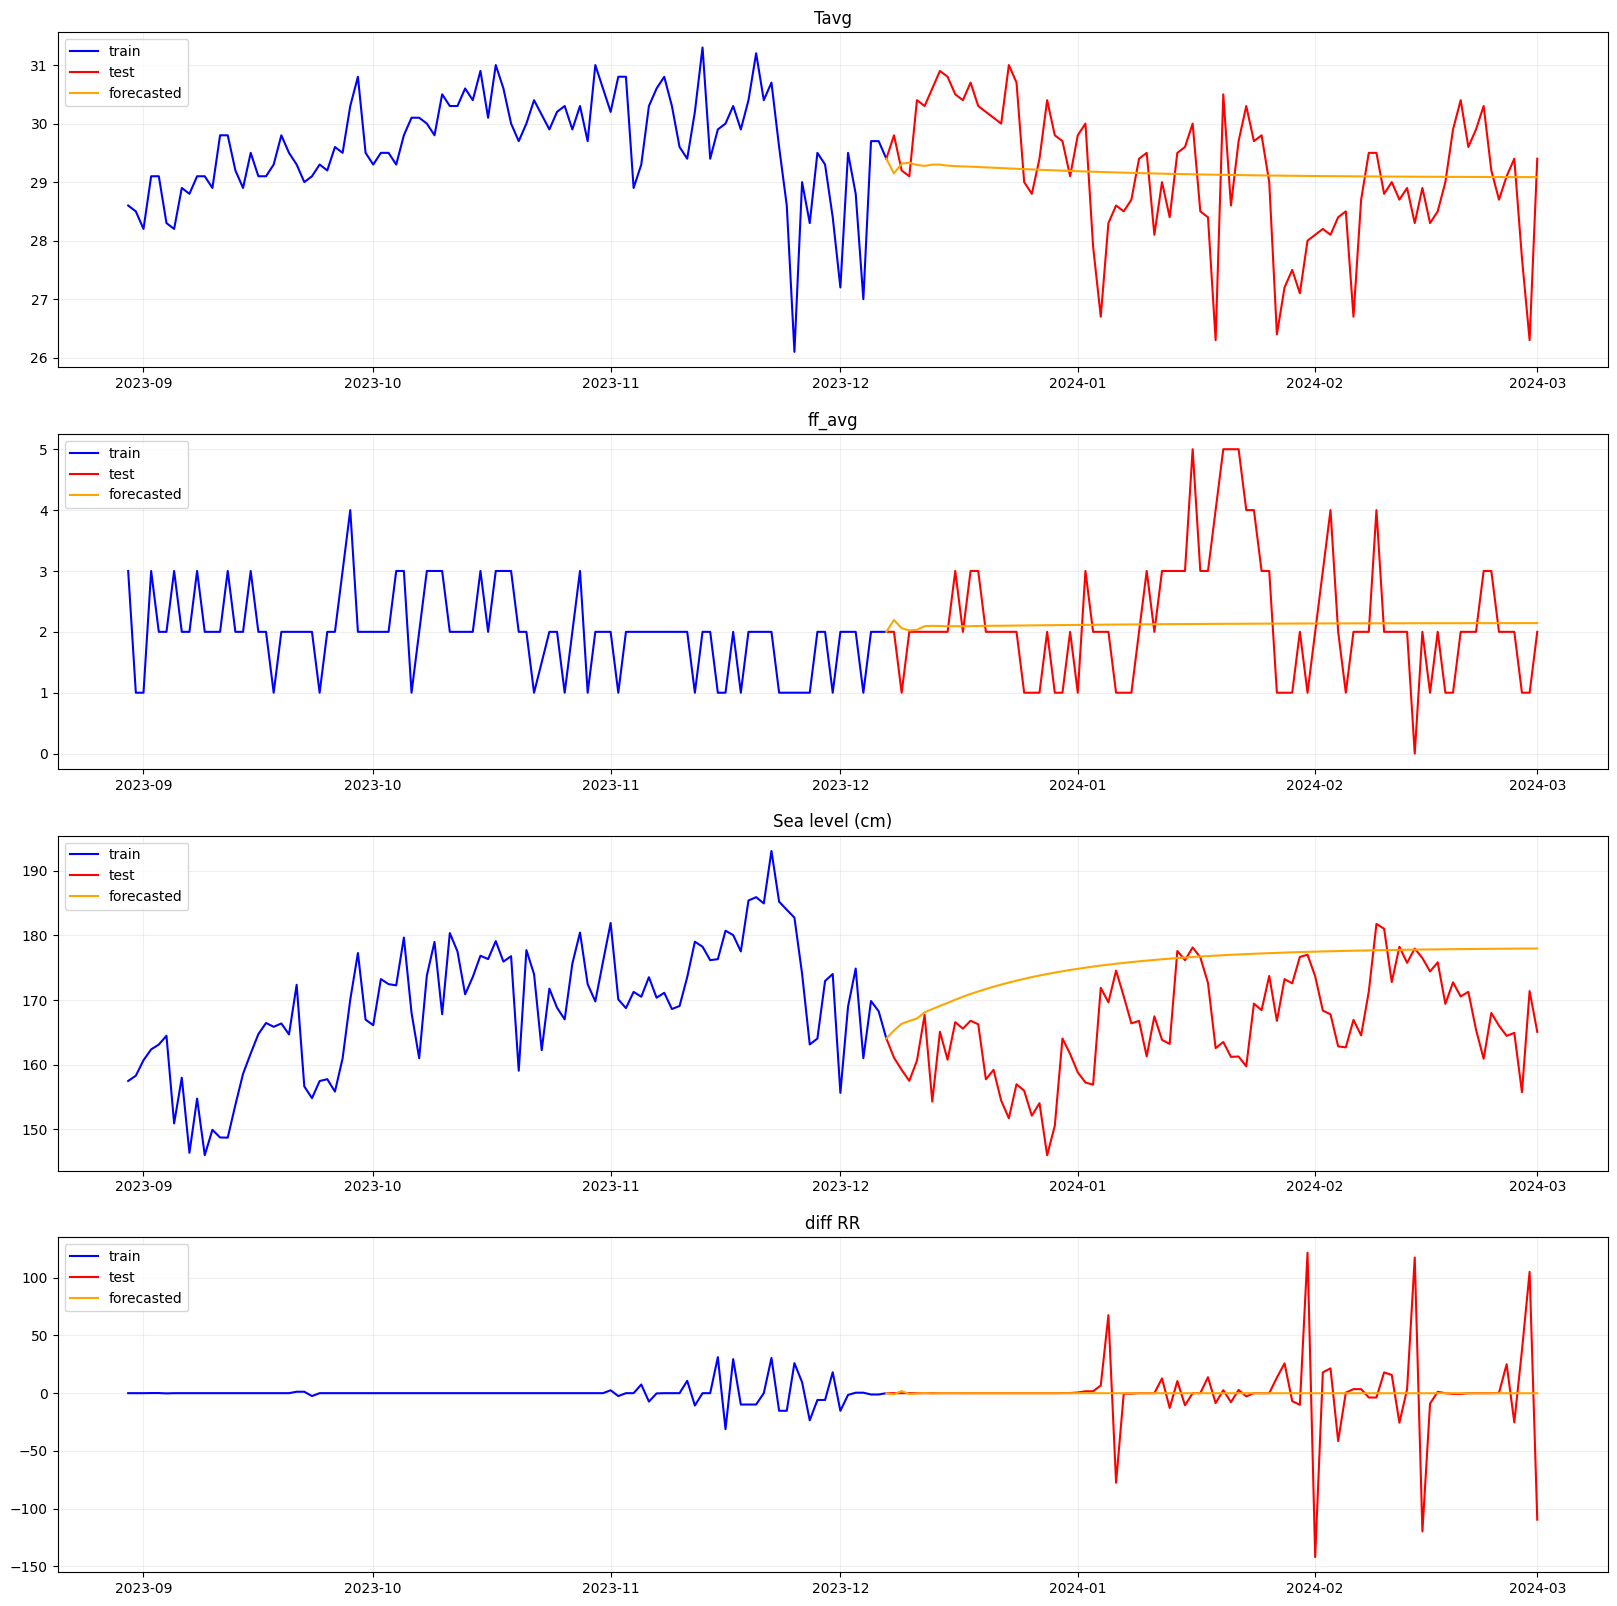

In [52]:
# Plot Train Eval split target only!

colour = ["blue", "red", "orange",]
fig = plt.figure(figsize=(20,20))
for counter, column in enumerate(train_data.columns):
    ax = fig.add_subplot(4,1,counter+1)
    ax.plot(train_data[column].iloc[-100:], label="train", c=colour[0])
    ax.plot(pd.concat((train_data[column].iloc[-1:],  test_data[column])), label="test", c=colour[1])
    ax.plot(pd.concat((train_data[column].iloc[-1:],  predictions_df[column])), label="forecasted", c=colour[2])

    ax.set_title(column, fontsize=12)
    ax.grid("on", alpha=0.2)
    ax.legend(loc="upper left")

In [53]:
def forecast_accuracy(pred_df, actual_df):
    logged = []
    for column in pred_df.columns:
        logged.append([column, mean_absolute_percentage_error(actual_df[column], pred_df[column]), np.sqrt(mean_squared_error(actual_df[column], pred_df[column]))])
    return pd.DataFrame(logged, columns=["column", "MAPE", "RMSE"])
forecast_accuracy(test_data, predictions_df)

,column,MAPE,RMSE
0,Tavg,0.029514,1.071886
1,ff_avg,0.354729,1.046180
2,Sea level (cm),0.053644,11.368562
3,diff RR,437.311721,35.189901


In [58]:
df_diff.to_csv("Data/temp-dfdiff.csv",index=None)

## BVAR

https://www.kaggle.com/code/rheyhanf/notebookd3edd6c915

In [368]:
predict_bvar = pd.read_table("DATA/savethis.txt", header=None).values.flatten().reshape(85,85,4)

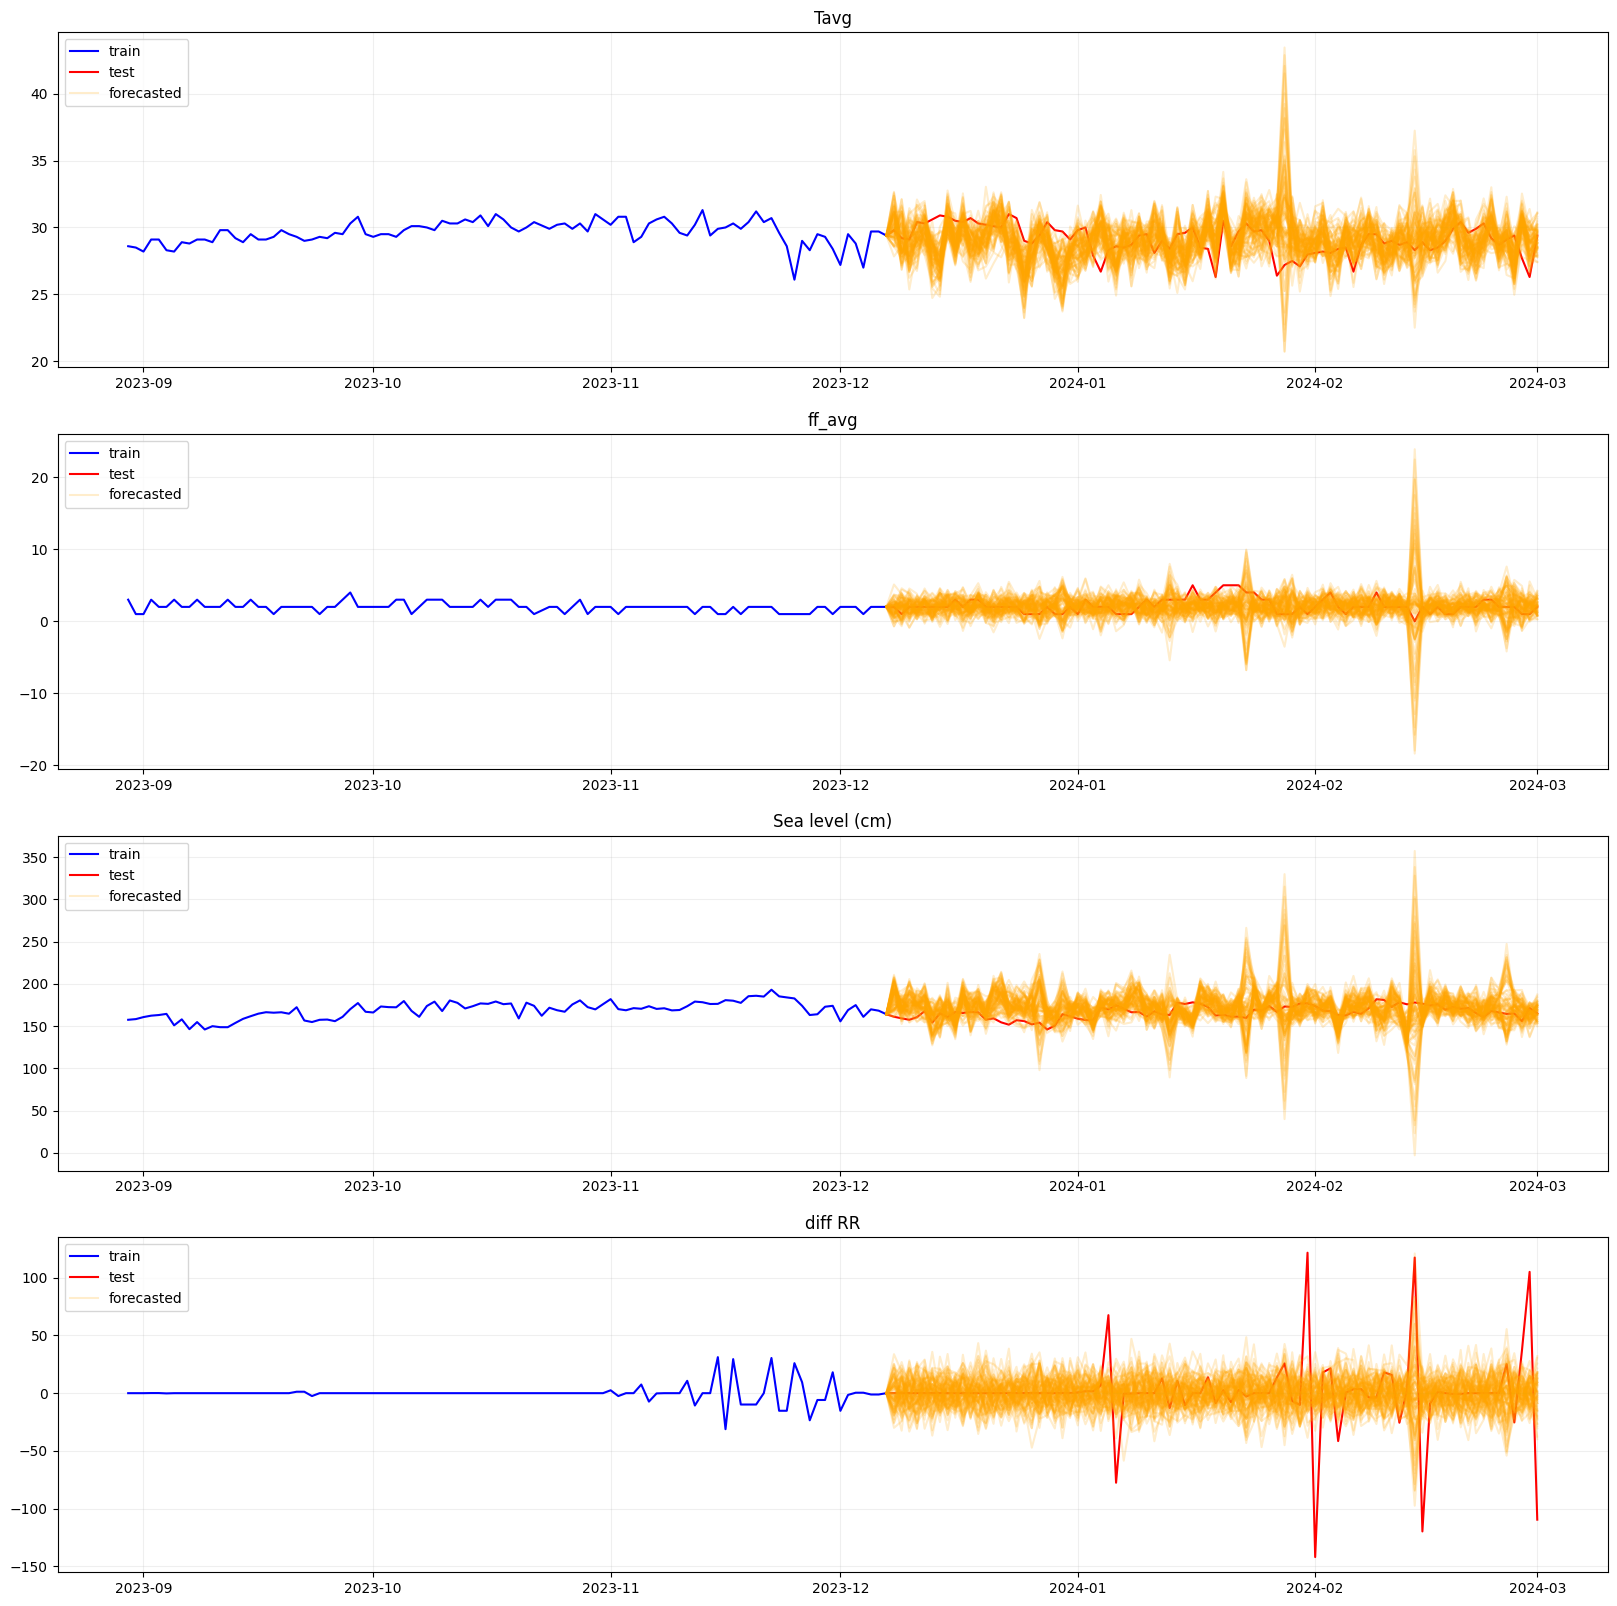

In [357]:
# Plot Train Eval split target only!

colour = ["blue", "red", "orange",]
fig = plt.figure(figsize=(20,20))
for counter, column in enumerate(train_data.columns):
    ax = fig.add_subplot(4,1,counter+1)
    ax.plot(train_data[column].iloc[-100:], label="train", c=colour[0])
    ax.plot(pd.concat((train_data[column].iloc[-1:],  test_data[column])), label="test", c=colour[1])
    for i in predict_bvar:
        temp= pd.concat((train_data[column].iloc[-1:], pd.DataFrame(i[:,counter], index=test_data.index, columns=[column])))
        ax.plot(temp, label="forecasted", c=colour[2], alpha=0.2)

    ax.set_title(column, fontsize=12)
    ax.grid("on", alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()  # Get current handles and labels
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper left")

In [369]:
predict_bvar.shape

(85, 85, 4)

In [391]:
temp = []
for i in range(85):
    for j in range(4):
        temp.append(np.mean(predict_bvar[:,i][:,j]))
temp = np.array(temp).reshape(85,4)

## Comparsion

In [399]:
def forecast_accuracy(pred_df, actual_df):
    logged = []
    for column in pred_df.columns:
        logged.append([column, mean_absolute_percentage_error(actual_df[column], pred_df[column]), np.sqrt(mean_squared_error(actual_df[column], pred_df[column]))])
    return pd.DataFrame(logged, columns=["column", "MAPE", "RMSE"])

print("BVAR")
print(forecast_accuracy(test_data, pd.DataFrame(temp, columns=df_diff.columns)))

print("VAR")
print(forecast_accuracy(test_data, predictions_df))

BVAR
           column       MAPE       RMSE
0            Tavg   0.038913   1.464048
1          ff_avg   0.382508   1.061355
2  Sea level (cm)   0.058162  12.387371
3         diff RR  37.684253  35.148585
VAR
           column        MAPE       RMSE
0            Tavg    0.029514   1.071886
1          ff_avg    0.354729   1.046180
2  Sea level (cm)    0.053644  11.368562
3         diff RR  437.311721  35.189901
